# Import Data

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# IMPT: make shortcut of the BT4012 Project folder inside your google drive so the stuff below works
drive.mount("/content/drive")
trainData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTrain.csv")
testData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTest.csv")
# maybe can combine both sets of data then split on our own for more credits?
allData = pd.concat([trainData, testData])

Mounted at /content/drive


# Processing Data for CatBoost

In [2]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [3]:
from sklearn.model_selection import train_test_split

# print(allData.corr())

# age grp
allData["age"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).year-pd.DatetimeIndex(allData["dob"]).year
allData["age_group"] = allData.apply(age_group,axis=1)

# trans times / age
allData["trans_hour"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).hour
allData["trans_yrmth"] = pd.DatetimeIndex(allData['trans_date_trans_time']).strftime('%Y-%m')
allData["weekday"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).weekday
allData["date"] = pd.to_datetime(allData['trans_date_trans_time']).dt.date

# drop redundant index column
allData.drop(labels="Unnamed: 0", axis=1, inplace=True)

# calculating the distance between the merchant location and transaction location
allData["latitude_difference"] = abs(allData["lat"]-allData["merch_lat"])
allData["longitude_difference"] = abs(allData["long"]-allData["merch_long"])

# it is estimated that difference between each degree of longitude and lattitude is approximately 69 miles which is 110 km
# applying pythogoras theorem
allData["distance"] = np.sqrt(pow(allData["latitude_difference"]*110,2)+pow(allData["longitude_difference"]*110,2))
allData['distance'].describe()

allData.category = allData.category.astype("category")
allData.gender = allData.gender.astype("category")
allData.state = allData.state.astype("category")
allData.age_group = allData.age_group.astype("category")
allData.trans_yrmth = allData.trans_yrmth.astype("category")
allData.weekday = allData.weekday.astype("category")
allData.job = allData.job.astype("category")
allData.city = allData.city.astype("category")
allData.is_fraud = allData.is_fraud.astype("category")
allData.trans_hour = allData.trans_hour.astype("category")

#can ignore others, just use train, validation, test
train, test = train_test_split(allData, test_size=0.2, random_state=4012)
del(allData)

onlyFraud = train[train.is_fraud == 1]
noFraud = train[train.is_fraud != 1]

print(onlyFraud)

       trans_date_trans_time            cc_num  \
288598   2019-05-21 23:40:29  6011438889172900   
644699   2019-10-01 01:45:49   346208242862904   
366597   2019-06-19 01:11:01  6506116513503136   
621562   2019-09-21 17:41:09  3565943051129759   
10057    2019-01-07 04:34:48  3597980945245815   
...                      ...               ...   
205282   2019-04-15 03:05:13  3548710338694745   
389704   2020-11-21 03:17:38    30235268718158   
204807   2020-09-01 01:10:19  4003989662068504   
93343    2019-02-24 22:33:25   180036456789979   
351029   2019-06-14 00:17:50  6011948324228984   

                                  merchant       category     amt      first  \
288598                fraud_Abbott-Steuber  personal_care   20.17    Allison   
644699                   fraud_Collier Inc    grocery_net   10.54    Tabitha   
366597               fraud_Dooley-Thompson       misc_net  773.63   Kimberly   
621562                     fraud_Lynch Ltd   shopping_pos  905.66      David   

In [4]:
train.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
train.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

test.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
test.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

In [5]:
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['amt', 'distance']] = scaler.fit_transform(X_train[['amt', 'distance']])
X_test[['amt', 'distance']] = scaler.transform(X_test[['amt', 'distance']])
X_train

,category,amt,gender,city,state,job,age_group,trans_hour,trans_yrmth,weekday,distance
1089385,shopping_net,-0.383380,M,Pembroke,NC,Hospital doctor,60 to 70,7,2020-03,6,0.128891
396245,gas_transport,0.034714,F,Centerview,MO,Electronics engineer,30 to 40,1,2019-06,6,1.050038
816379,misc_net,2.015096,M,Oakland,TN,Furniture conservator/restorer,20 to 30,5,2019-12,6,-0.889407
476241,shopping_pos,0.166698,F,Lakeport,CA,Podiatrist,40 to 50,12,2020-12,0,0.763506
567642,kids_pets,-0.354002,M,San Antonio,TX,Exhibition designer,40 to 50,20,2019-08,3,0.458453
...,...,...,...,...,...,...,...,...,...,...,...
1286615,misc_pos,-0.397409,F,Sutherland,NE,Insurance broker,30 to 40,23,2020-06,1,-0.678208
926319,shopping_net,0.181167,F,Steuben,ME,Make,60 to 70,3,2020-01,3,1.222068
83164,misc_pos,-0.374762,F,Tulsa,OK,Bookseller,50 to 60,9,2020-07,0,-0.064892
301454,travel,-0.400114,F,Allentown,PA,"Scientist, research (maths)",20 to 30,23,2019-05,6,-1.963438


# CatBoostClassifier

In [7]:
!pip install catboost
import random
import time
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

categorical_variables = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_hour', 'trans_yrmth', 'weekday']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


## Baseline Model

In [8]:
baseline_clf = CatBoostClassifier(cat_features=categorical_variables,
                                  random_state=4012)

start_time = time.perf_counter()
baseline_clf.fit(X_train, y_train)
baseline_training_time = time.perf_counter() - start_time

Learning rate set to 0.232742
0:	learn: 0.2642521	total: 1.31s	remaining: 21m 48s
1:	learn: 0.0809477	total: 4.54s	remaining: 37m 44s
2:	learn: 0.0364947	total: 7.02s	remaining: 38m 53s
3:	learn: 0.0242812	total: 9.97s	remaining: 41m 23s
4:	learn: 0.0186857	total: 14.2s	remaining: 47m 12s
5:	learn: 0.0141762	total: 19s	remaining: 52m 20s
6:	learn: 0.0096133	total: 25.1s	remaining: 59m 25s
7:	learn: 0.0082243	total: 30.5s	remaining: 1h 2m 57s
8:	learn: 0.0070890	total: 36.3s	remaining: 1h 6m 41s
9:	learn: 0.0065178	total: 39.1s	remaining: 1h 4m 33s
10:	learn: 0.0061503	total: 41.1s	remaining: 1h 1m 35s
11:	learn: 0.0058147	total: 43.3s	remaining: 59m 26s
12:	learn: 0.0055785	total: 45.5s	remaining: 57m 37s
13:	learn: 0.0053589	total: 47.8s	remaining: 56m 8s
14:	learn: 0.0051035	total: 51.3s	remaining: 56m 6s
15:	learn: 0.0049567	total: 53.6s	remaining: 54m 54s
16:	learn: 0.0048075	total: 56.7s	remaining: 54m 36s
17:	learn: 0.0048049	total: 58.3s	remaining: 52m 58s
18:	learn: 0.0047185	t

In [9]:
print(baseline_training_time)

2821.223089943


In [10]:
pred_test_baseline = baseline_clf.predict(X_test)
print(confusion_matrix(y_test, pred_test_baseline))
print(classification_report(y_test, pred_test_baseline))

[[368503     31]
 [    99   1846]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.98      0.95      0.97      1945

    accuracy                           1.00    370479
   macro avg       0.99      0.97      0.98    370479
weighted avg       1.00      1.00      1.00    370479



In [11]:
from sklearn.metrics import roc_auc_score

print("Baseline Classifier (Not Tuned): ", roc_auc_score(y_test, pred_test_baseline))

Baseline Classifier (Not Tuned):  0.9745080700000779


We notice that the performance of the untuned CatBoostClassifier is already extremely good. However, we should still try our best to tune the many hyperparameters that are available for us to specify. Hopefully, we can get a better result.

## Hyperparameter Tuning

In order to find out if we should use CatBoost's native randomised search cross-validation function or use sklearn's implementation, we first tried out a simple randomised search with a few parameters (notably without the _max_iterations_ parameter tuned as it would significantly increase grid search time). We try this out on a classifier with relatively small number of iterations (20, as compared to the default value of 1000), so as to widen the scope of other parameters that we can search for.

In [ ]:
params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'loss_function': ['Logloss', 'AUC'],
          'min_data_in_leaf': [2, 3, 4, 5]}

clf = CatBoostClassifier(iterations=20,
                         cat_features=categorical_variables,
                         random_state=4012)

rscv_clf = RandomizedSearchCV(clf, params)
rscv_clf.fit(X_train, y_train)
pred_test = rscv_clf.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

0:	learn: 0.1382034	total: 1.5s	remaining: 28.5s
1:	learn: 0.0547083	total: 3.59s	remaining: 32.4s
2:	learn: 0.0235686	total: 6.9s	remaining: 39.1s
3:	learn: 0.0131377	total: 9.92s	remaining: 39.7s
4:	learn: 0.0092216	total: 12.8s	remaining: 38.3s
5:	learn: 0.0070428	total: 15.3s	remaining: 35.7s
6:	learn: 0.0064523	total: 18.3s	remaining: 34s
7:	learn: 0.0062964	total: 20.8s	remaining: 31.3s
8:	learn: 0.0061747	total: 22.6s	remaining: 27.6s
9:	learn: 0.0061733	total: 23.2s	remaining: 23.2s
10:	learn: 0.0061733	total: 24s	remaining: 19.7s
11:	learn: 0.0058207	total: 27.1s	remaining: 18.1s
12:	learn: 0.0056409	total: 28.8s	remaining: 15.5s
13:	learn: 0.0054099	total: 30.2s	remaining: 12.9s
14:	learn: 0.0048207	total: 31.5s	remaining: 10.5s
15:	learn: 0.0045913	total: 33s	remaining: 8.24s
16:	learn: 0.0044893	total: 34.5s	remaining: 6.09s
17:	learn: 0.0044893	total: 35s	remaining: 3.88s
18:	learn: 0.0044893	total: 35.4s	remaining: 1.86s
19:	learn: 0.0044893	total: 35.8s	remaining: 0us
0:

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5126, in fit
    CatBoostClassifier._check_is_compatible_loss(params['loss_function'])
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5479, in _check_is_compatible_loss
    "Logloss, CrossEntropy, MultiClass, MultiClassOneV

0:	learn: 0.1382343	total: 1.07s	remaining: 20.4s
1:	learn: 0.0543479	total: 3.12s	remaining: 28.1s
2:	learn: 0.0235930	total: 5.44s	remaining: 30.8s
3:	learn: 0.0143724	total: 7.11s	remaining: 28.4s
4:	learn: 0.0439703	total: 9.42s	remaining: 28.3s
5:	learn: 0.2037287	total: 11.2s	remaining: 26.2s
6:	learn: 0.1929639	total: 12.9s	remaining: 24s
7:	learn: 0.1909812	total: 15s	remaining: 22.5s
8:	learn: 0.1835112	total: 16.6s	remaining: 20.3s
9:	learn: 0.1793814	total: 19.1s	remaining: 19.1s
10:	learn: 0.1720439	total: 21.8s	remaining: 17.8s
11:	learn: 0.1755875	total: 24s	remaining: 16s
12:	learn: 0.1720718	total: 25.1s	remaining: 13.5s
13:	learn: 0.1714124	total: 26.8s	remaining: 11.5s
14:	learn: 0.1711511	total: 29.2s	remaining: 9.73s
15:	learn: 0.1448182	total: 31.4s	remaining: 7.86s
16:	learn: 0.1447131	total: 33.5s	remaining: 5.91s
17:	learn: 0.1425305	total: 35.2s	remaining: 3.91s
18:	learn: 0.1424211	total: 36.9s	remaining: 1.94s
19:	learn: 0.1414973	total: 38.7s	remaining: 0us


In [ ]:
rscv_clf.best_params_

{'random_strength': 0.5,
 'min_data_in_leaf': 4,
 'max_depth': 6,
 'max_ctr_complexity': 3,
 'loss_function': 'Logloss',
 'learning_rate': 1.0,
 'l2_leaf_reg': 8}

In [ ]:
params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5]}

clf2 = CatBoostClassifier(iterations=20,
                         cat_features=categorical_variables,
                         random_state=4012)

res2 = clf2.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2474598	test: 0.2470126	best: 0.2470126 (0)	total: 1.3s	remaining: 24.8s
1:	learn: 0.0782702	test: 0.0778397	best: 0.0778397 (1)	total: 2.45s	remaining: 22s
2:	learn: 0.0361343	test: 0.0357258	best: 0.0357258 (2)	total: 3.67s	remaining: 20.8s
3:	learn: 0.0221962	test: 0.0217957	best: 0.0217957 (3)	total: 4.89s	remaining: 19.6s
4:	learn: 0.0164266	test: 0.0160540	best: 0.0160540 (4)	total: 5.93s	remaining: 17.8s
5:	learn: 0.0138095	test: 0.0134549	best: 0.0134549 (5)	total: 7.12s	remaining: 16.6s
6:	learn: 0.0126960	test: 0.0123182	best: 0.0123182 (6)	total: 8.17s	remaining: 15.2s
7:	learn: 0.0120067	test: 0.0116451	best: 0.0116451 (7)	total: 9.2s	remaining: 13.8s
8:	learn: 0.0114779	test: 0.0111297	best: 0.0111297 (8)	total: 10.2s	remaining: 12.5s
9:	learn: 0.0110899	test: 0.0107293	best: 0.0107293 (9)	total: 11.3s	remaining: 11.3s
10:	learn: 0.0108076	test: 0.0104349	best: 0.0104349 (10)	total: 12.5s	remaining: 10.2s
11:	learn: 0.0106613	test: 0.0102988	best: 0.0102988 (11

In [ ]:
res2['params']

{'min_data_in_leaf': 4,
 'max_ctr_complexity': 3,
 'depth': 9,
 'l2_leaf_reg': 4,
 'random_strength': 0.2,
 'learning_rate': 0.6666666666666666}

In [ ]:
pred_test = clf2.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

[[368465     69]
 [   162   1783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.96      0.92      0.94      1945

    accuracy                           1.00    370479
   macro avg       0.98      0.96      0.97    370479
weighted avg       1.00      1.00      1.00    370479



For the same parameter distribution, we find that CatBoost's implementation for grid search was able to achieve a much higher recall for the fraudulent transactions (92% compared to sklearn's of 84%).

With a recall score of over 90%, we are satisfied, but want to try and see if increasing the number of iterations will yield a better result - or if the clasifier will become overfitted to the training data. We test out for an iteration of 100.

In [ ]:
clf3 = CatBoostClassifier(iterations=100,
                          cat_features=categorical_variables,
                          min_data_in_leaf=4,
                          max_ctr_complexity=3,
                          depth=9,
                          l2_leaf_reg=4,
                          random_strength=0.2,
                          learning_rate=0.66666666666,
                          random_state=4012)

clf3.fit(X_train, y_train)
pred_test = clf3.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

0:	learn: 0.2421866	total: 1.07s	remaining: 1m 45s
1:	learn: 0.1132932	total: 5.01s	remaining: 4m 5s
2:	learn: 0.0590704	total: 8.51s	remaining: 4m 35s
3:	learn: 0.0329432	total: 12s	remaining: 4m 46s
4:	learn: 0.0199979	total: 15.4s	remaining: 4m 53s
5:	learn: 0.0135817	total: 18.5s	remaining: 4m 49s
6:	learn: 0.0135060	total: 22.1s	remaining: 4m 53s
7:	learn: 0.0066157	total: 26.1s	remaining: 5m
8:	learn: 0.0067646	total: 29.1s	remaining: 4m 54s
9:	learn: 0.0052328	total: 31.8s	remaining: 4m 45s
10:	learn: 0.0048611	total: 34.4s	remaining: 4m 37s
11:	learn: 0.0047658	total: 36.3s	remaining: 4m 26s
12:	learn: 0.0044179	total: 39s	remaining: 4m 21s
13:	learn: 0.0042047	total: 41.5s	remaining: 4m 14s
14:	learn: 0.0041335	total: 45.3s	remaining: 4m 16s
15:	learn: 0.0040198	total: 50.5s	remaining: 4m 25s
16:	learn: 0.0039385	total: 56.1s	remaining: 4m 33s
17:	learn: 0.0038269	total: 59.3s	remaining: 4m 29s
18:	learn: 0.0037860	total: 1m 2s	remaining: 4m 24s
19:	learn: 0.0037322	total: 1m 

In [15]:
clf3 = CatBoostClassifier(iterations=100,
                          cat_features=categorical_variables,
                          min_data_in_leaf=4,
                          max_ctr_complexity=3,
                          depth=9,
                          l2_leaf_reg=4,
                          random_strength=0.2,
                          learning_rate=0.66666666666,
                          random_state=4012)

clf3.fit(X_train, y_train)

0:	learn: 0.2421866	total: 1.9s	remaining: 3m 8s
1:	learn: 0.1132932	total: 9.42s	remaining: 7m 41s
2:	learn: 0.0590704	total: 16.2s	remaining: 8m 44s
3:	learn: 0.0329432	total: 21.7s	remaining: 8m 41s
4:	learn: 0.0199979	total: 25.8s	remaining: 8m 10s
5:	learn: 0.0135817	total: 29s	remaining: 7m 33s
6:	learn: 0.0135060	total: 34.9s	remaining: 7m 43s
7:	learn: 0.0066157	total: 40.9s	remaining: 7m 49s
8:	learn: 0.0067646	total: 45.4s	remaining: 7m 38s
9:	learn: 0.0052328	total: 48.9s	remaining: 7m 20s
10:	learn: 0.0048611	total: 53.3s	remaining: 7m 11s
11:	learn: 0.0047658	total: 56.9s	remaining: 6m 57s
12:	learn: 0.0044179	total: 1m 1s	remaining: 6m 52s
13:	learn: 0.0042047	total: 1m 5s	remaining: 6m 43s
14:	learn: 0.0041335	total: 1m 10s	remaining: 6m 40s
15:	learn: 0.0040198	total: 1m 16s	remaining: 6m 40s
16:	learn: 0.0039385	total: 1m 19s	remaining: 6m 27s
17:	learn: 0.0038269	total: 1m 22s	remaining: 6m 14s
18:	learn: 0.0037860	total: 1m 24s	remaining: 6m 1s
19:	learn: 0.0037322	t

With a recall score of 93%, we can see that we are able to get a higher recall score (and F1-score as well). Hence, we perform grid search over larger values of iterations to see how well we can do.

In [9]:
params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5],
          'iterations': [250, 500, 1000],
          'border_count': [127, 254, 500],
          }

clf4 = CatBoostClassifier(cat_features=categorical_variables,
                         random_state=4012)

res4 = clf4.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
786:	learn: 0.0013188	test: 0.0088661	best: 0.0070597 (46)	total: 15m 5s	remaining: 4m 5s
787:	learn: 0.0013160	test: 0.0088628	best: 0.0070597 (46)	total: 15m 7s	remaining: 4m 4s
788:	learn: 0.0013091	test: 0.0088629	best: 0.0070597 (46)	total: 15m 8s	remaining: 4m 2s
789:	learn: 0.0013044	test: 0.0088689	best: 0.0070597 (46)	total: 15m 9s	remaining: 4m 1s
790:	learn: 0.0013020	test: 0.0088801	best: 0.0070597 (46)	total: 15m 10s	remaining: 4m
791:	learn: 0.0012960	test: 0.0088960	best: 0.0070597 (46)	total: 15m 11s	remaining: 3m 59s
792:	learn: 0.0012890	test: 0.0088969	best: 0.0070597 (46)	total: 15m 12s	remaining: 3m 58s
793:	learn: 0.0012849	test: 0.0089025	best: 0.0070597 (46)	total: 15m 13s	remaining: 3m 57s
794:	learn: 0.0012794	test: 0.0089090	best: 0.0070597 (46)	total: 15m 15s	remaining: 3m 56s
795:	learn: 0.0012768	test: 0.0089173	best: 0.0070597 (46)	total: 15m 16s	remaining: 3m 54s
796:	learn: 0.0012751	test: 0.0089190	bes

In [10]:
res4['params']

{'border_count': 127,
 'min_data_in_leaf': 4,
 'depth': 7,
 'max_ctr_complexity': 4,
 'l2_leaf_reg': 8,
 'iterations': 1000,
 'random_strength': 0.2,
 'learning_rate': 0.2222222222222222}

In [11]:
pred_test = clf4.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

[[368503     31]
 [   102   1843]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.98      0.95      0.97      1945

    accuracy                           1.00    370479
   macro avg       0.99      0.97      0.98    370479
weighted avg       1.00      1.00      1.00    370479



In [18]:
start_time = time.perf_counter()
clf4_time = CatBoostClassifier(cat_features=categorical_variables,
                         random_state=4012,
                         **res4['params'])
clf4_time.fit(X_train, y_train)
clf4_train_time = time.perf_counter() - start_time

0:	learn: 0.2464708	total: 1.78s	remaining: 29m 38s
1:	learn: 0.0823675	total: 7.53s	remaining: 1h 2m 36s
2:	learn: 0.0384022	total: 14.8s	remaining: 1h 21m 55s
3:	learn: 0.0256409	total: 22.8s	remaining: 1h 34m 37s
4:	learn: 0.0165608	total: 28.6s	remaining: 1h 34m 51s
5:	learn: 0.0117829	total: 35s	remaining: 1h 36m 34s
6:	learn: 0.0089107	total: 42.7s	remaining: 1h 40m 51s
7:	learn: 0.0072655	total: 50.3s	remaining: 1h 43m 55s
8:	learn: 0.0064034	total: 55.5s	remaining: 1h 41m 50s
9:	learn: 0.0056948	total: 58.4s	remaining: 1h 36m 18s
10:	learn: 0.0053013	total: 1m 1s	remaining: 1h 32m 35s
11:	learn: 0.0049959	total: 1m 5s	remaining: 1h 29m 55s
12:	learn: 0.0047702	total: 1m 8s	remaining: 1h 27m 8s
13:	learn: 0.0045763	total: 1m 11s	remaining: 1h 24m 10s
14:	learn: 0.0044146	total: 1m 14s	remaining: 1h 21m 41s
15:	learn: 0.0042994	total: 1m 16s	remaining: 1h 18m 46s
16:	learn: 0.0042152	total: 1m 20s	remaining: 1h 17m 18s
17:	learn: 0.0040690	total: 1m 23s	remaining: 1h 16m 2s
18:	l

In [19]:
print(clf4_train_time)

3115.3655146589954


We print out the ROC AUC score for all 4 classifiers and compare them.

In [16]:
pred_y_1 = clf1.predict(X_test)
print("Classifier 1 (sklearn RandomizedSearchCV): ", roc_auc_score(y_test, pred_y_1))
pred_y_2 = clf2.predict(X_test)
print("Classifier 2 (CatBoost RandomizedSearchCV): ", roc_auc_score(y_test, pred_y_2))
pred_y_3 = clf3.predict(X_test)
print("Classifier 3 (100 iterations): ", roc_auc_score(y_test, pred_y_3))
pred_y_4 = clf4.predict(X_test)
print("Classifier 4 (Finalised Model): ", roc_auc_score(y_test, pred_y_4))

Classifier 1 (sklearn RandomizedSearchCV):  0.9197060965364847
Classifier 2 (CatBoost RandomizedSearchCV):  0.9582611416263449
Classifier 3 (100 iterations):  0.9649517298882113
Classifier 4 (Finalised Model):  0.9737368617738569


After performing the tuning and running the grid search, we realise that the baseline model for CatBoost is actually much better. Hence, we shall revert to the baseline model in assessing model explainability.

Note: We do not tune for more values of parameters, as we are limited by our computing power (the above grid search, for example, took about 8 hours to run on our computer).

# Model Explainability

After identifying the best classifier, we want to analyse the model to understand how and why it makes the predictions. As CatBoost is a tree-based classifier, we can plot one of the trees generated by the algorithm.

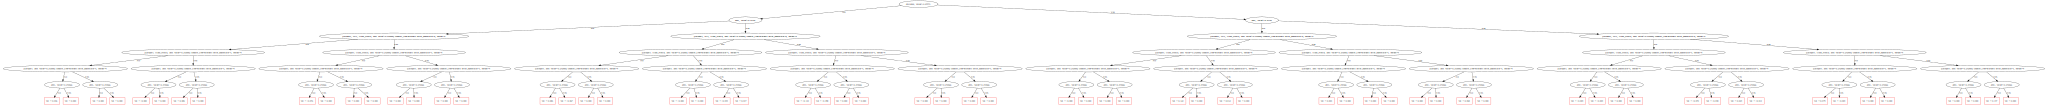

In [14]:
from catboost import Pool

pool = Pool(X_train, y_train, cat_features=categorical_variables, feature_names=list(X_train.columns))
tree = baseline_clf.plot_tree(tree_idx=999, pool=pool)
tree

Although decision trees are fairly self-explainable, with such a large dataset and multiple features, the decision tree generated might not be as intuitive/generate as much insights for us. However, we can rely on other packages and aspects in order to analyse our model.

In [15]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 3.9 MB/s 


Using a sample data point as an example, we are able to see how the different values of the various features affect the model's prediction value.

In [16]:
shap_values = baseline_clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

Using SHAP, we are also able to get an aggregate view on how the features affect the prediction at a model-level. We see that _amt_, _category_ and _trans_hour_ are the features that affect the model's prediction the most.

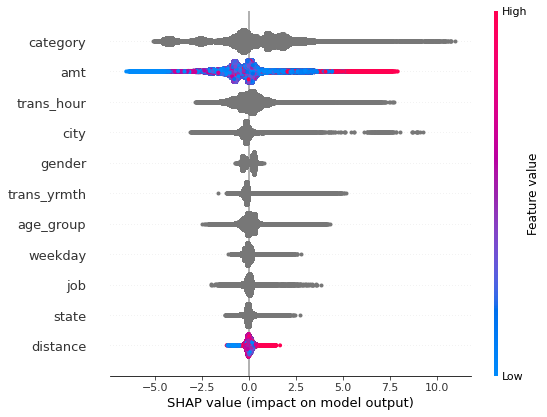

In [17]:
shap_values = baseline_clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test)

CatBoost also has in-built support to analyse feature importance, and we shall use it as another way to analyse the model.

In [18]:
from sklearn.metrics import log_loss

def get_feature_imp_plot(method):
    fi = baseline_clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type=method)
    
    feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                    columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
    ax.set_xlabel("features")
    plt.show()

For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.

Here, we see that based off this metric, factors like _category_, _amt_ and _city_ are the most important.

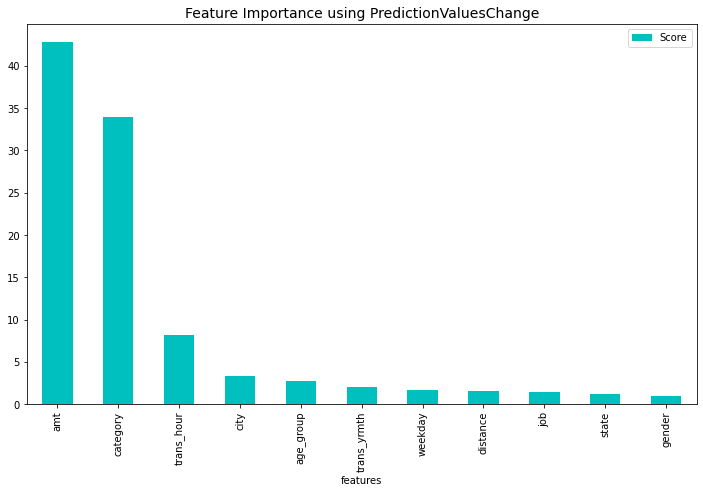

In [19]:
get_feature_imp_plot(method="PredictionValuesChange")

For each feature, the LossFunctionChange value represents the difference between the loss value of the model with this feature and without it. The model without this feature is equivalent to the one that would have been trained if this feature was excluded from the dataset. Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble.

Here, we see factors like _amt_, _city_ and _trans_yrmth_ being the most influential features.

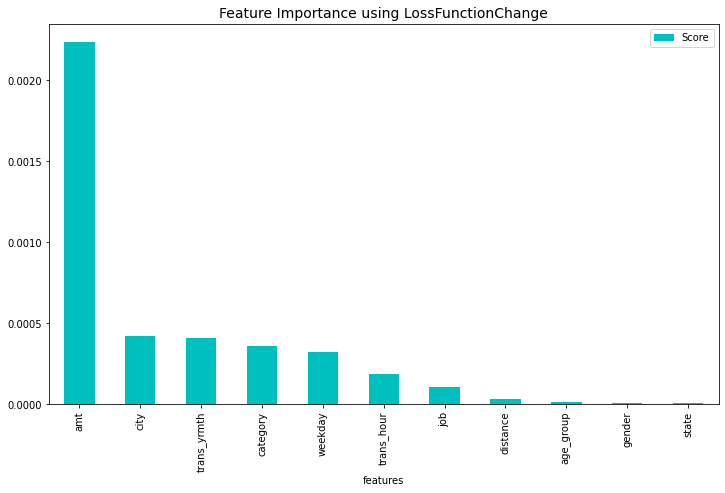

In [20]:
get_feature_imp_plot(method="LossFunctionChange")

Although there are many ways to analyse feature importance - and each with their own way of calculating so, the key thing is that we see that there is some congruence between the different methods. There are several overlapping factors that rank amongst the most important when using the various methods, and we are satisfied with the explainability provided by these explanations.